In [1]:
import os
import sys

os.environ["PYSPARK_PYTHON"]="C:\Spark\spark-3.3.2-bin-hadoop2\python"
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-18.0.2.1"
os.environ["SPARK_HOME"] = "C:\Spark\spark-3.3.2-bin-hadoop2"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.9.5-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("r_model").getOrCreate()
spark

In [2]:
cluster_data = spark.read.option("header","true").csv("../data/EDA/clustering_data.csv")
cluster_data = cluster_data.drop("_c0")
cluster_data.printSchema()

cluster_data = cluster_data.drop("subject_id","hadm_id")
print(cluster_data.count())



root
 |-- subject_id: string (nullable = true)
 |-- hadm_id: string (nullable = true)
 |-- age: string (nullable = true)
 |-- db_wbc: string (nullable = true)
 |-- basophils_abs: string (nullable = true)
 |-- eosinophils_abs: string (nullable = true)
 |-- lymphocytes_abs: string (nullable = true)
 |-- monocytes_abs: string (nullable = true)
 |-- neutrophils_abs: string (nullable = true)
 |-- basophils: string (nullable = true)
 |-- eosinophils: string (nullable = true)
 |-- lymphocytes: string (nullable = true)
 |-- monocytes: string (nullable = true)
 |-- neutrophils: string (nullable = true)
 |-- aniongap: string (nullable = true)
 |-- bicarbonate: string (nullable = true)
 |-- bun: string (nullable = true)
 |-- calcium: string (nullable = true)
 |-- chloride: string (nullable = true)
 |-- creatinine: string (nullable = true)
 |-- glucose: string (nullable = true)
 |-- sodium: string (nullable = true)
 |-- potassium: string (nullable = true)
 |-- inr: string (nullable = true)
 |-- pt

In [5]:
import pyspark.sql.functions as F
print(cluster_data.printSchema())
numeric_cols = cluster_data.columns
numeric_cols.remove("gender")
cluster_data = cluster_data.select(*(F.round(F.col(c).cast("double"), 2).alias(c) for c in numeric_cols), "gender")
print(cluster_data.printSchema())

root
 |-- age: string (nullable = true)
 |-- db_wbc: string (nullable = true)
 |-- basophils_abs: string (nullable = true)
 |-- eosinophils_abs: string (nullable = true)
 |-- lymphocytes_abs: string (nullable = true)
 |-- monocytes_abs: string (nullable = true)
 |-- neutrophils_abs: string (nullable = true)
 |-- basophils: string (nullable = true)
 |-- eosinophils: string (nullable = true)
 |-- lymphocytes: string (nullable = true)
 |-- monocytes: string (nullable = true)
 |-- neutrophils: string (nullable = true)
 |-- aniongap: string (nullable = true)
 |-- bicarbonate: string (nullable = true)
 |-- bun: string (nullable = true)
 |-- calcium: string (nullable = true)
 |-- chloride: string (nullable = true)
 |-- creatinine: string (nullable = true)
 |-- glucose: string (nullable = true)
 |-- sodium: string (nullable = true)
 |-- potassium: string (nullable = true)
 |-- inr: string (nullable = true)
 |-- pt: string (nullable = true)
 |-- ptt: string (nullable = true)
 |-- hematocrit: st

In [6]:
# replace gender M, F to 1, 2, anyother values to 0
cluster_data = cluster_data.withColumn("gender_imputed", F.when(F.col("gender") == 'M', 1) \
                           .when(F.col("gender") == 'F', 2) \
                           .otherwise(0))
cluster_data.groupby("gender_imputed").count().toPandas()

,gender_imputed,count
0,1,57
1,2,43


In [9]:
cluster_data = cluster_data.drop("gender")
cluster_data.printSchema()

root
 |-- age: double (nullable = true)
 |-- db_wbc: double (nullable = true)
 |-- basophils_abs: double (nullable = true)
 |-- eosinophils_abs: double (nullable = true)
 |-- lymphocytes_abs: double (nullable = true)
 |-- monocytes_abs: double (nullable = true)
 |-- neutrophils_abs: double (nullable = true)
 |-- basophils: double (nullable = true)
 |-- eosinophils: double (nullable = true)
 |-- lymphocytes: double (nullable = true)
 |-- monocytes: double (nullable = true)
 |-- neutrophils: double (nullable = true)
 |-- aniongap: double (nullable = true)
 |-- bicarbonate: double (nullable = true)
 |-- bun: double (nullable = true)
 |-- calcium: double (nullable = true)
 |-- chloride: double (nullable = true)
 |-- creatinine: double (nullable = true)
 |-- glucose: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- potassium: double (nullable = true)
 |-- inr: double (nullable = true)
 |-- pt: double (nullable = true)
 |-- ptt: double (nullable = true)
 |-- hematocrit: do

In [11]:
# fill the missing values with the median value
from pyspark.ml.feature import Imputer


print (cluster_data.describe().toPandas())
imputer = Imputer(
    inputCols = numeric_cols, 
    outputCols = ["{}_imputed".format(c) for c in numeric_cols]
    ).setStrategy("median")

# Add imputation cols to df
cluster_data = imputer.fit(cluster_data).transform(cluster_data)

  summary                 age             db_wbc        basophils_abs  \
0   count                 100                100                   63   
1    mean  62.360399999999984              14.49  0.06063492063492061   
2  stddev  16.093590537976304  8.628745709849868  0.06229153662476343   
3     min               21.16                2.4                  0.0   
4     max               91.77               62.4                 0.26   

       eosinophils_abs    lymphocytes_abs       monocytes_abs  \
0                   63                 63                  63   
1  0.23873015873015868  3.034444444444444  0.9249206349206349   
2  0.31759932184605055  7.104795013677731  0.6162919108718221   
3                  0.0               0.25                0.26   
4                  1.9              57.41                3.84   

      neutrophils_abs           basophils         eosinophils  ...  \
0                  63                  63                  63  ...   
1   12.62555555555556   0.4650

In [12]:
cluster_data.printSchema()

root
 |-- age: double (nullable = true)
 |-- db_wbc: double (nullable = true)
 |-- basophils_abs: double (nullable = true)
 |-- eosinophils_abs: double (nullable = true)
 |-- lymphocytes_abs: double (nullable = true)
 |-- monocytes_abs: double (nullable = true)
 |-- neutrophils_abs: double (nullable = true)
 |-- basophils: double (nullable = true)
 |-- eosinophils: double (nullable = true)
 |-- lymphocytes: double (nullable = true)
 |-- monocytes: double (nullable = true)
 |-- neutrophils: double (nullable = true)
 |-- aniongap: double (nullable = true)
 |-- bicarbonate: double (nullable = true)
 |-- bun: double (nullable = true)
 |-- calcium: double (nullable = true)
 |-- chloride: double (nullable = true)
 |-- creatinine: double (nullable = true)
 |-- glucose: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- potassium: double (nullable = true)
 |-- inr: double (nullable = true)
 |-- pt: double (nullable = true)
 |-- ptt: double (nullable = true)
 |-- hematocrit: do

In [14]:
cluster_data.columns

['age',
 'db_wbc',
 'basophils_abs',
 'eosinophils_abs',
 'lymphocytes_abs',
 'monocytes_abs',
 'neutrophils_abs',
 'basophils',
 'eosinophils',
 'lymphocytes',
 'monocytes',
 'neutrophils',
 'aniongap',
 'bicarbonate',
 'bun',
 'calcium',
 'chloride',
 'creatinine',
 'glucose',
 'sodium',
 'potassium',
 'inr',
 'pt',
 'ptt',
 'hematocrit',
 'hemoglobin',
 'mch',
 'mchc',
 'mcv',
 'platelet',
 'rbc',
 'rdw',
 'wbc',
 'scr_min',
 'ckd',
 'mdrd_est',
 'scr_baseline',
 'alt',
 'alp',
 'ast',
 'bilirubin_total',
 'gender_imputed',
 'age_imputed',
 'db_wbc_imputed',
 'basophils_abs_imputed',
 'eosinophils_abs_imputed',
 'lymphocytes_abs_imputed',
 'monocytes_abs_imputed',
 'neutrophils_abs_imputed',
 'basophils_imputed',
 'eosinophils_imputed',
 'lymphocytes_imputed',
 'monocytes_imputed',
 'neutrophils_imputed',
 'aniongap_imputed',
 'bicarbonate_imputed',
 'bun_imputed',
 'calcium_imputed',
 'chloride_imputed',
 'creatinine_imputed',
 'glucose_imputed',
 'sodium_imputed',
 'potassium_impu

In [15]:
cluster_data2 = cluster_data.select([c for c in cluster_data.columns if "_imputed" in c])

In [16]:
cluster_data2.printSchema()

root
 |-- gender_imputed: integer (nullable = false)
 |-- age_imputed: double (nullable = true)
 |-- db_wbc_imputed: double (nullable = true)
 |-- basophils_abs_imputed: double (nullable = true)
 |-- eosinophils_abs_imputed: double (nullable = true)
 |-- lymphocytes_abs_imputed: double (nullable = true)
 |-- monocytes_abs_imputed: double (nullable = true)
 |-- neutrophils_abs_imputed: double (nullable = true)
 |-- basophils_imputed: double (nullable = true)
 |-- eosinophils_imputed: double (nullable = true)
 |-- lymphocytes_imputed: double (nullable = true)
 |-- monocytes_imputed: double (nullable = true)
 |-- neutrophils_imputed: double (nullable = true)
 |-- aniongap_imputed: double (nullable = true)
 |-- bicarbonate_imputed: double (nullable = true)
 |-- bun_imputed: double (nullable = true)
 |-- calcium_imputed: double (nullable = true)
 |-- chloride_imputed: double (nullable = true)
 |-- creatinine_imputed: double (nullable = true)
 |-- glucose_imputed: double (nullable = true)
 |

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_checkerboard
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score

In [49]:
data = cluster_data2.toPandas()
n_clusters = (4, 3)
model_bi = SpectralBiclustering(n_clusters=n_clusters, method="bistochastic", random_state=0)
model_bi.fit(data)

SpectralBiclustering(n_clusters=(4, 3), random_state=0)

In [23]:
np.argsort(model_bi.row_labels_)

array([ 0, 70, 69, 68, 67, 66, 65, 64, 62, 61, 71, 60, 58, 57, 56, 55, 54,
       53, 52, 51, 50, 59, 72, 73, 74, 96, 95, 94, 93, 92, 91, 90, 89, 88,
       87, 86, 85, 84, 83, 82, 80, 79, 78, 77, 76, 75, 98, 48, 49, 46, 47,
       20, 19, 18, 16, 15, 14, 13, 12, 23, 11,  9,  8,  7,  6,  5,  4,  3,
        2,  1, 10, 24, 22, 26, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 25,
       35, 33, 32, 31, 30, 29, 28, 27, 34, 99, 81, 17, 63, 21, 97],
      dtype=int64)

In [24]:
np.argsort(model_bi.column_labels_)

array([ 0, 23, 24, 25, 26, 27, 28, 29, 22, 30, 32, 33, 34, 35, 36, 37, 39,
       31, 21, 20,  9,  1,  2,  3,  4,  5,  6,  7,  8, 19, 41, 11, 12, 13,
       14, 15, 16, 17, 18, 10, 40, 38], dtype=int64)

In [50]:
fit_data = data.iloc[np.argsort(model_bi.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model_bi.column_labels_)]

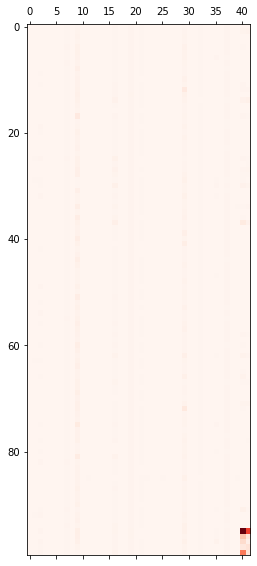

In [51]:
plt.matshow(fit_data, cmap=plt.cm.Reds)


Text(0.5, 1.0, 'structure of rearranged data')

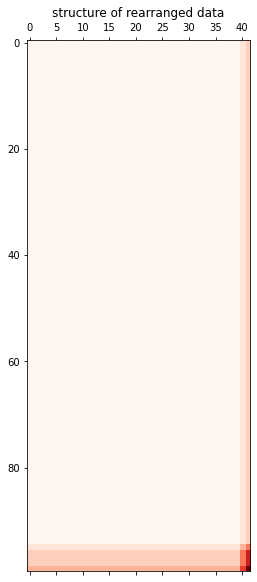

In [54]:
plt.matshow(
    np.outer(np.sort(model_bi.row_labels_) + 1, np.sort(model_bi.column_labels_) + 1),
    cmap=plt.cm.Reds,
)
plt.title("structure of rearranged data")